# AI in Medicine I - Practical 2: Brain Tissue Segmentation

Segmentation of different tissues from MRI scans of the brain is an important step for further downstream applications such as disease prediction, classification or brain age estimation.

The goal of the coursework is to implement classical and deep learning approaches for segmentation of different tissue types in MRI scans of the brain, i.e., background, cerebrospinal fluid (CSF), white matter (WM), and gray matter (GM). We provide data from a total of 652 healthy subjects, that is split into different development sets and a hold-out test set on which you will evaluate your final segmentation accuracy.
Each approach will require a processing pipeline with different components that you will need to implement using methods that were discussed in the lectures and tutorials. There are three dedicated parts in the Jupyter notebook for each approach which contain some detailed instructions and some helper code.

**Make sure to select the correct runtime when working in Google Colab (GPU)**

## Downloading the Data

In [ ]:
! wget -q --show-progress https://www.dropbox.com/s/w9njau9t6rrheel/brainage-data.zip
! unzip -qq -o brainage-data.zip
! wget -q --show-progress https://www.dropbox.com/s/f5mt8p9pkszff3x/brainage-testdata.zip
! unzip -qq -o brainage-testdata.zip


## Imports

In [5]:
import os
import glob
import random
from argparse import Namespace
from functools import partial
from multiprocessing import Pool
from numbers import Number
from typing import Any, Dict
from typing import List, Tuple

import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm


def seed_everything(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False


def mean_absolute_error(preds: Tensor, targets: Tensor) -> float:
    """Compute the mean absolute error between predictions and targets"""
    return (preds.view(-1) - targets.view(-1)).abs().mean().item()


class TensorboardLogger(SummaryWriter):
    def __init__(
        self,
        log_dir: str = None,
        config: Namespace = None,
        enabled: bool = True,
        comment: str = '',
        purge_step: int = None,
        max_queue: int = 10,
        flush_secs: int = 120,
        filename_suffix: str = ''
    ):
        self.enabled = enabled
        if self.enabled:
            super().__init__(
                log_dir=log_dir,
                comment=comment,
                purge_step=purge_step,
                max_queue=max_queue,
                flush_secs=flush_secs,
                filename_suffix=filename_suffix
            )
        else:
            return

        # Add config
        if config is not None:
            self.add_hparams(
                {k: v for k, v in vars(config).items() if isinstance(
                    v, (int, float, str, bool, torch.Tensor))},
                {}
            )

    def log(self, data: Dict[str, Any], step: int) -> None:
        """Log each entry in data as its corresponding data type"""
        if self.enabled:
            for k, v in data.items():
                # Scalars
                if isinstance(v, Number):
                    self.add_scalar(k, v, step)

                # Images
                elif (isinstance(v, np.ndarray) or isinstance(v, torch.Tensor)) and len(v.shape) >= 3:
                    if len(v.shape) == 3:
                        self.add_image(k, v, step)
                    elif len(v.shape) == 4:
                        self.add_images(k, v, step)
                    else:
                        raise ValueError(f'Unsupported image shape: {v.shape}')

                # Matplotlib figures
                elif isinstance(v, plt.Figure):
                    self.add_figure(k, v, step)

                else:
                    raise ValueError(f'Unsupported data type: {type(v)}')


def load_nii(path: str, dtype: str = 'float32') -> np.ndarray:
    """Load an MRI scan from disk and convert it to a given datatype

    :param path: Path to file
    :param dtype: Target dtype
    :return img: Loaded image. Shape (H, W, D)
    """
    return nib.load(path).get_fdata().astype(np.dtype(dtype))


def load_segmentations(paths: str):
    """Load all segmentations and associated subject_ids"""
    filenames, segmentations = [], []
    for im in tqdm(paths):
        id = im.split('_brain_')[0].split('/')[-1].split('-')[1].split('_')[0]
        segmentations.append(load_nii(im))
        filenames.append(id)
    return filenames, np.array(segmentations)


def plot_segmentations(im: np.ndarray, seg: np.ndarray, i: int = 65, title: str = None):
    fig, ax = plt.subplots(2, 3, figsize=(20, 10))

    col = 2
    ax[0, col].imshow(np.rot90(im[..., i], k=3), cmap='gray')
    ax[0, col].imshow(np.rot90(seg[..., i], k=3),
                 alpha=0.5 * (np.rot90(seg[..., i] > 0, k=3)),
                 interpolation=None, cmap='jet')
    ax[1, col].imshow(np.rot90(im[..., i], k=3), cmap='gray')
    ax[0, col].set_title('Axial')

    k = 1
    col = 0
    ax[0, col].imshow(np.rot90(im[i, ...], k=k), cmap='gray')
    ax[0, col].imshow(np.rot90(seg[i, ...], k=k),
                 alpha=0.5 * (np.rot90(seg[i, ...] > 0, k=k)),
                 interpolation=None, cmap='jet')
    ax[1, col].imshow(np.rot90(im[i, ...], k=k), cmap='gray')
    ax[0, col].set_title('Sagittal')

    col = 1
    ax[0, col].imshow(np.rot90(im[:, i, :], k=k), cmap='gray')
    ax[0, col].imshow(np.rot90(seg[:, i, :], k=k),
                 alpha=0.5 * (np.rot90(seg[:, i, :] > 0, k=k)),
                 interpolation=None, cmap='jet')
    ax[1, col].imshow(np.rot90(im[:, i, :], k=k), cmap='gray')
    ax[0, col].set_title('Coronal')

    if title is not None:
        # plt.set_title(title)
        fig.suptitle(title, fontsize=16)

    plt.tight_layout()
    plt.show()



%load_ext tensorboard
%load_ext autoreload
%autoreload 2

## Getting started and familiarise ourselves with the data

We provide the data of 652 subjects from which we use 522 for training, 65 for validation, and the rest of 65 for testing your final model.

## Imaging data
Let's check out the imaging data that is available for each subject.

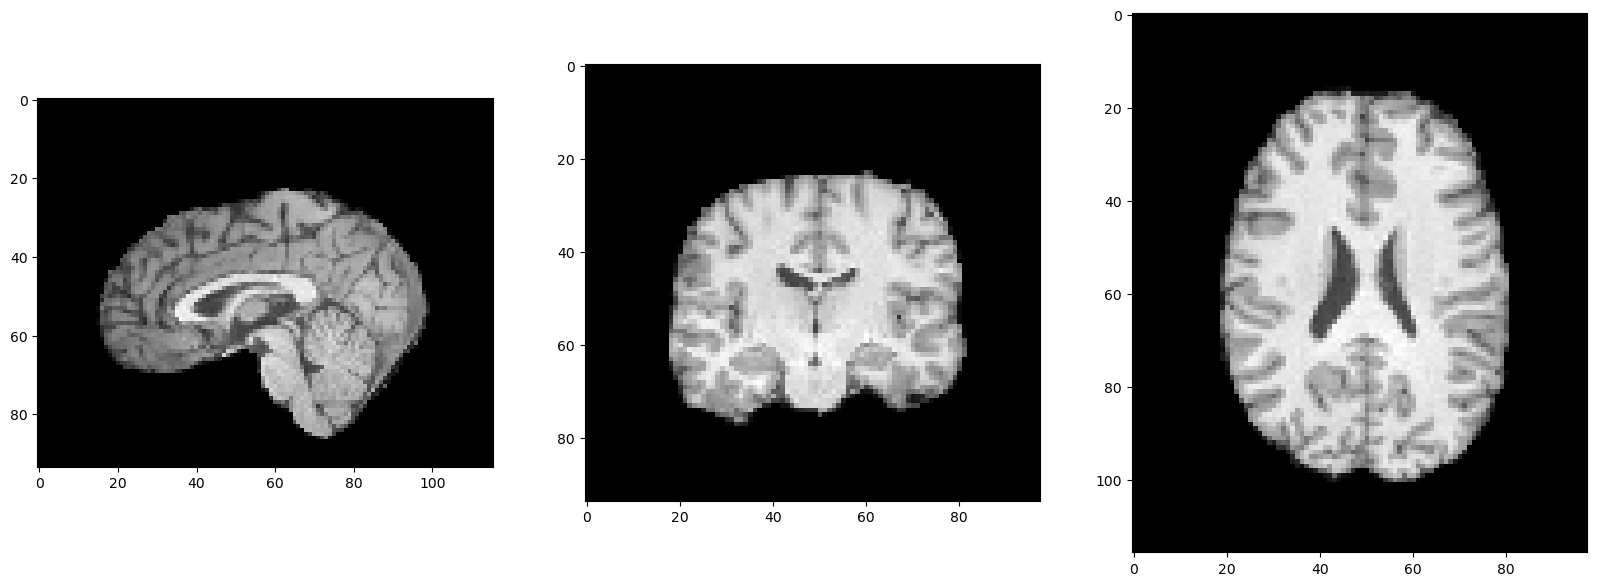

In [3]:
file = './data/brain_age/images/sub-CC110033_T1w_unbiased.nii.gz'

image = nib.load(file).get_fdata()

f, axarr = plt.subplots(1, 3, figsize=(20, 10))
H, W, D = image.shape
axarr[0].imshow(np.flip(image[H // 2, :, :].T, axis=0), cmap='gray')
axarr[1].imshow(np.flip(image[:, W // 2, :].T, axis=0), cmap='gray')
axarr[2].imshow(image[:, :, D // 2].T, cmap='gray')
plt.show()

## Data loading and visualization

Let's first load all the data and make a tranin/val/test split

In [6]:
paths = sorted(glob.glob('data/brain_age/segs_refs/*'))
filenames, segmentations = load_segmentations(paths)

100%|██████████| 652/652 [00:03<00:00, 183.86it/s]


In [7]:
np.random.seed(10282022)

all_keys = np.asarray(range(len(filenames)))
ratio_test = int(0.1 * len(all_keys))  # 10% val; 10% test
val_keys = np.random.choice(all_keys, 2 * ratio_test, replace=False)
test_keys = np.random.choice(val_keys, ratio_test, replace=False)

train_files, val_files, test_files = [], [], []
segmentations_train, segmentations_val, segmentations_test =  [],  [], []
for scan_id in tqdm(all_keys):
  scan = f'data/brain_age/images/sub-{filenames[scan_id]}_T1w_unbiased.nii.gz'
  seg = segmentations[scan_id]
  if scan_id in test_keys:
      test_files.append(scan)
      segmentations_test.append(seg)
  elif scan_id in val_keys:
      val_files.append(scan)
      segmentations_val.append(seg)
  else:
      train_files.append(scan)
      segmentations_train.append(seg)
print(f'{len(train_files)} train files')
print(f'{len(val_files)} val files')
print(f'{len(test_files)} test files')

100%|██████████| 652/652 [00:00<00:00, 127070.59it/s]

522 train files
65 val files
65 test files


Let's visualize one validations sample

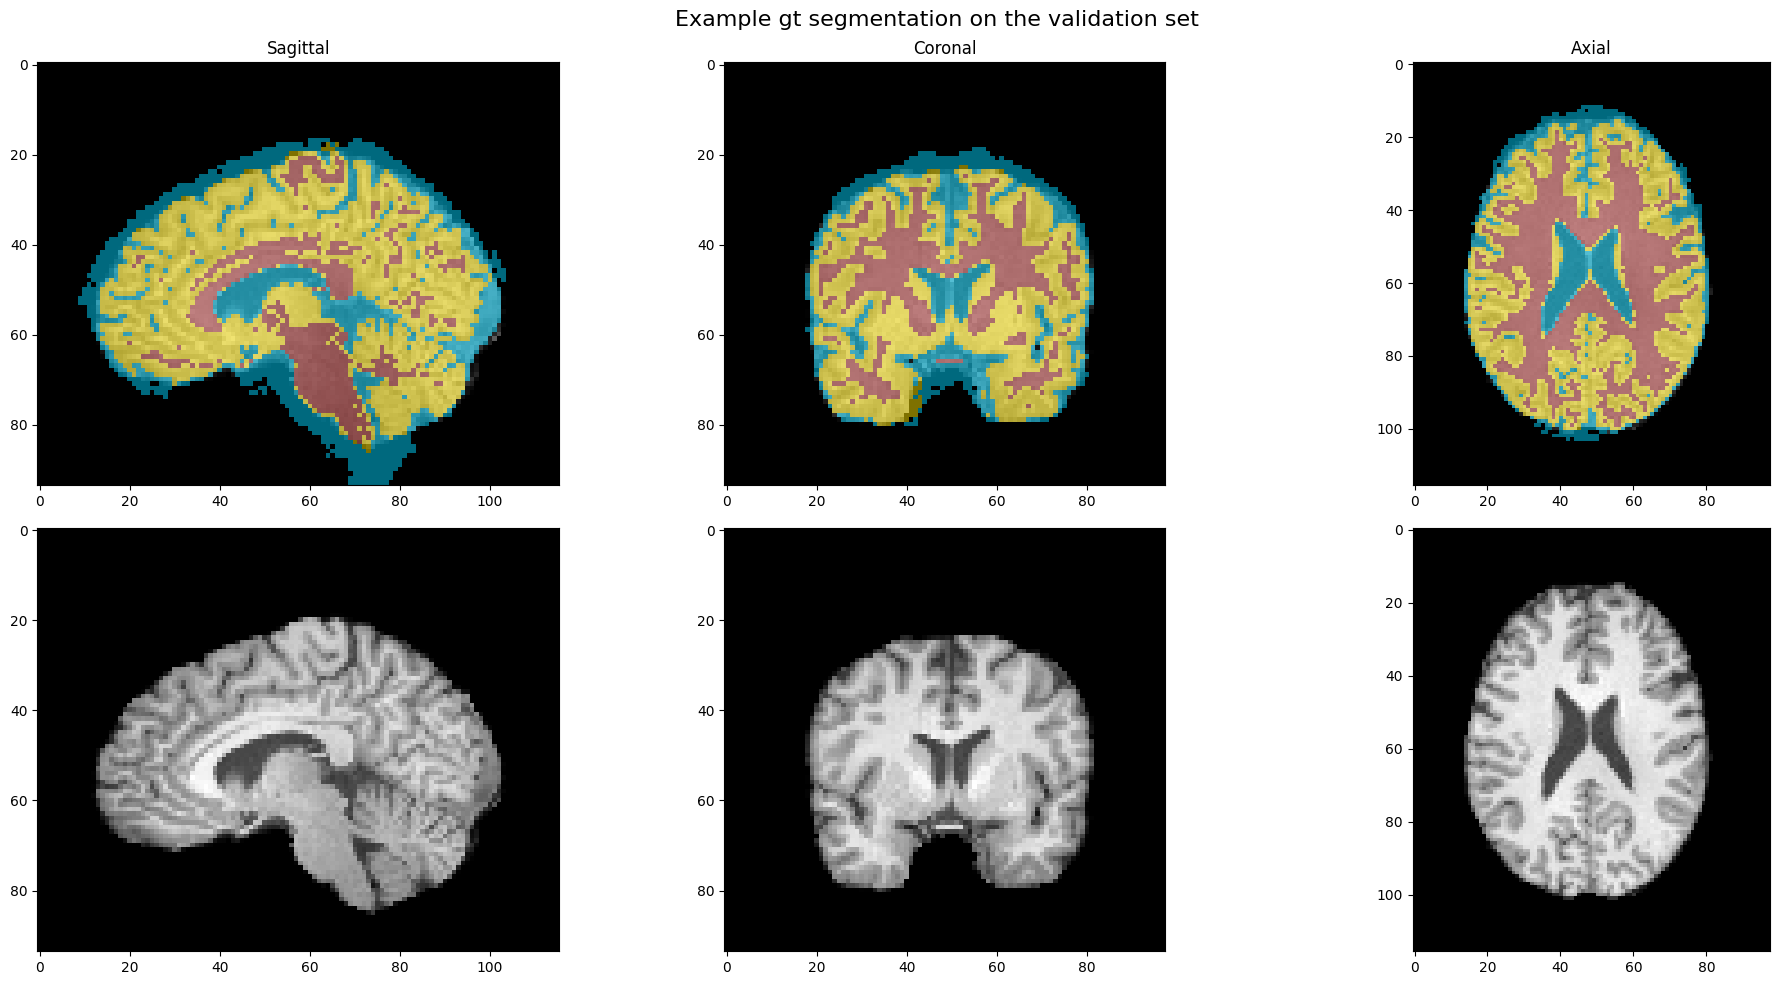

In [5]:
im = load_nii(val_files[0])
plot_segmentations(im, segmentations_val[0], i=47, title='Example gt segmentation on the validation set')

# Task 1: Evaluation and Visualization

**Q1a**. We first have to define how good our predicted segmentations are. Implement the evaluation functions below.

In [8]:
np.unique(np.array(segmentations_test)[15])

array([0., 1., 2., 3.], dtype=float32)

In [8]:
# The Dice similarity coefficient is widely used for evaluating image segmentation alogrithms.
# Implement a method that computes the patient-wise Dice score, precision, and recall (mean and std) for the test dataset.
# Hint: Don't forget that there are multiple classes.
# --------------------------- ADD YOUR CODE HERE ------------------------------

def dice_coefficient_precision_recall(predictions, gt): 
  predictions = np.array(predictions)
  gt = np.array(gt)

  unique_classes = np.unique(gt)
  num_classes = len(unique_classes)
  num_patients = predictions.shape[0]

  dice = np.zeros((num_classes, num_patients))
  precision = np.zeros((num_classes, num_patients))
  recall = np.zeros((num_classes, num_patients))

  for patient_idx in range(num_patients):
      for i, cls in enumerate(unique_classes):
        pred = predictions[patient_idx, :, :, :]
        ground_truth = gt[patient_idx, :, :, :]

        true_positive = np.sum(np.logical_and(pred == cls, ground_truth == cls))
        false_positive = np.sum(np.logical_and(pred == cls, ground_truth != cls))
        false_negative = np.sum(np.logical_and(pred != cls, ground_truth == cls))

        # Calculate Dice, precision, and recall for the current class and patient
        dice[i, patient_idx] = (2.0 * true_positive) / (2.0 * true_positive + false_positive + false_negative + 1e-5)
        precision[i, patient_idx] = true_positive / (true_positive + false_positive + 1e-5)
        recall[i, patient_idx] = true_positive / (true_positive + false_negative + 1e-5)

  return dice, precision, recall
def Dice(predictions, gt):

  dice, _, _ = dice_coefficient_precision_recall(predictions, gt)
  mean, std = dice.mean(axis=0), dice.std(axis=0)
  return mean, std

def precision(predictions, gt):

  _, precision, _ = dice_coefficient_precision_recall(predictions, gt)
  mean, std = precision.mean(axis=0) , precision.std(axis=0)
  return mean, std

def recall(predictions, gt):

  _, _, recall = dice_coefficient_precision_recall(predictions, gt)
  mean, std = recall.mean(axis=0), recall.std(axis=0)
  return mean, std

# ----------------------------------- END -------------------------------------

**Q1b**. Next, we want to visualize the best- and worst-performing samples in the test set. Implement a function that evaluates the entire test dataset and outputs the index of the best and worst performing samples according to the Dice coefficient.

In [9]:
# You may change the functions below as you see fit

# --------------------------- ADD YOUR CODE HERE ------------------------------
def get_best_and_worst_ids(predictions):
    best_ids, worst_ids = -1, -1

    # TODO: implement
    dice_scores = Dice(predictions, segmentations_test)[0]

    # Find the index of the best and worst Dice scores
    best_ids = np.argmax(dice_scores)
    worst_ids = np.argmin(dice_scores)
    # print(dice_scores.shape)
    best_performance, worst_performance = dice_scores[best_ids], dice_scores[worst_ids]
    return {
        'best_id': best_ids,
        'best_performance': best_performance,
        'worst_id': worst_ids,
        'worst_performance': worst_performance
    }

def visualize_best_and_worst_samples(predictions, i_best=47, i_worst=47):
    return_dict = get_best_and_worst_ids(predictions)

    best_id = return_dict['best_id']
    plot_segmentations(load_nii(test_files[best_id]), predictions[best_id], i=i_best,
                       title=f'Best prediction on the test set (Dice: {return_dict["best_performance"]:.2f})')

    worst_id = return_dict['worst_id']
    plot_segmentations(load_nii(test_files[worst_id]), predictions[worst_id], i=i_worst,
                       title=f'Worst prediction on the test set (Dice: {return_dict["worst_performance"]:.2f})')

# ----------------------------------- END -------------------------------------

**Q1c**. Given a set of predictions for a number of models, create a summary figure of your choice (e.g. table, bar plot) which visualizes all of the metric values. Visualize multiple metrics (Dice coefficient, precision, and recall), each computed for every tissue type. A sample dictionary is provided below.

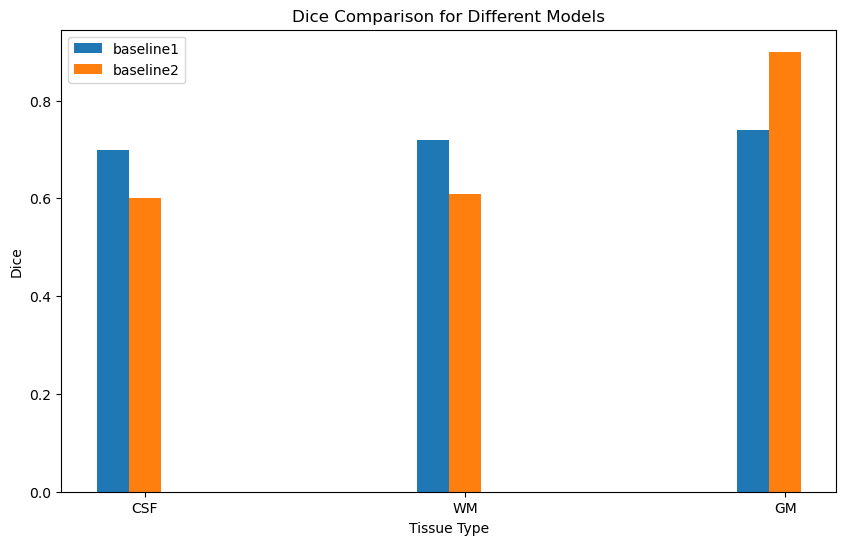

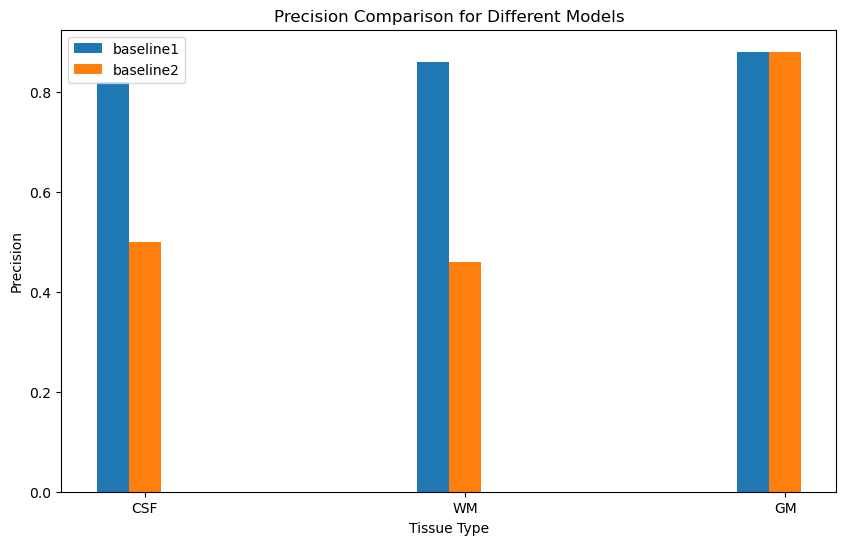

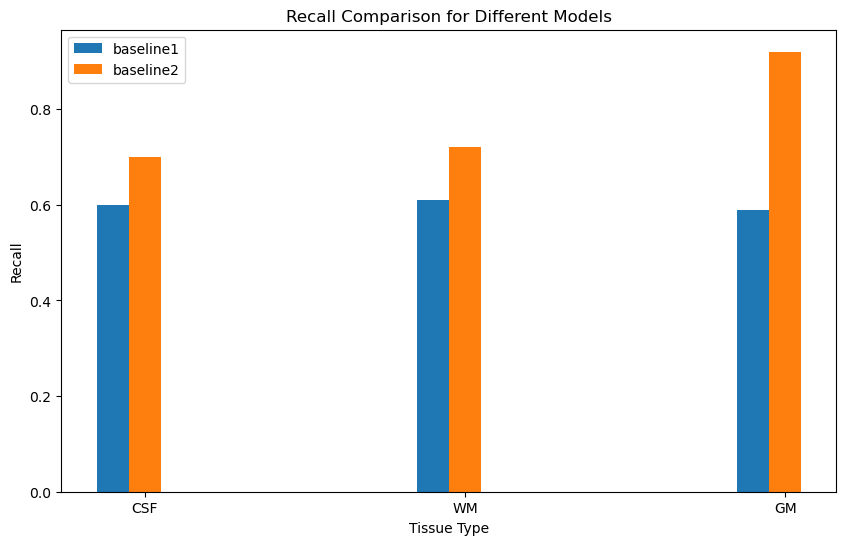

In [10]:
# --------------------------- ADD YOUR CODE HERE ------------------------------

def get_results_dictionary(predictions):
    results_dict = {}
    tissues = ['CSF', 'WM', 'GM']
    for i, tissue in enumerate(tissues): 

        dict_ = {'dice': '-1', 'precision': '-1', 'recall': '-1'}

        dict_['dice'] = str(Dice(predictions[i], segmentations_test)[0].mean())
        dict_['precision'] = str(precision(predictions[i], segmentations_test)[0].mean())
        dict_['recall'] = str(recall(predictions[i], segmentations_test)[0].mean())
        
        results_dict[tissues[i]] = dict_

    return results_dict

def plot_results_summary(results_dict: Dict[str, Dict[str, Dict[str, str]]]) -> None:
    
    tissues = list(next(iter(results_dict.values())).keys())
    metrics = ['dice', 'precision', 'recall']
    models = list(results_dict.keys())

    bar_width = 0.1
    index = np.arange(len(tissues))

    for metric in metrics:
        plt.figure(figsize=(10, 6))
        for i, model in enumerate(models):
            values = [float(results_dict[model][tissue][metric]) for tissue in tissues]
            plt.bar(index + i * bar_width, values, bar_width, label=model)

        plt.xlabel('Tissue Type')
        plt.ylabel(metric.capitalize())
        plt.title(f'{metric.capitalize()} Comparison for Different Models')
        plt.xticks(index + (len(models) / 2) * bar_width, tissues)
        plt.legend()

        plt.show()
# ----------------------------------- END -------------------------------------

sample_results = {
    'baseline1': {
        'CSF': {'dice': '0.7', 'precision': '0.82', 'recall': '0.6'},
        'WM': {'dice': '0.72', 'precision': '0.86', 'recall': '0.61'},
        'GM': {'dice': '0.74', 'precision': '0.88', 'recall': '0.59'},
    },
    'baseline2': {
        'CSF': {'dice': '0.6', 'precision': '0.5', 'recall': '0.7'},
        'WM': {'dice': '0.61', 'precision': '0.46', 'recall': '0.72'},
        'GM': {'dice': '0.9', 'precision': '0.88', 'recall': '0.92'},
    }
}
plot_results_summary(sample_results)

# Task 2: Unsupervised segmentation

The first approach aims to segment the brain tissues, including grey matter (GM), white matter (WM), cerebrospinal fluid (CSF), and background using unsupervised classical machine learning techniques.

Different unsupervised techniques to leverage the different intensity profile of the tissues should be explored.

In [ ]:
slice_id = 0
im_ = load_nii(val_files[slice_id])[:,:,47].flatten()
seg_ = segmentations_val[slice_id][:,:,47].flatten()

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)
fig.suptitle('Intensity Density Plot')

sns.kdeplot(im_, ax=axes[0], fill=True)
axes[0].set_title('Input')

sns.kdeplot(im_[np.argwhere(seg_ == 0)][:, 0], ax=axes[1], fill=True, color='#85929E', label='Background', legend=True)
sns.kdeplot(im_[np.argwhere(seg_ == 1)][:, 0], ax=axes[1], fill=True, color='#9FE2BF', label='CSF', legend=True)
sns.kdeplot(im_[np.argwhere(seg_ == 3)][:, 0], ax=axes[1], fill=True, color='#CD5C5C', label='WM', legend=True)
sns.kdeplot(im_[np.argwhere(seg_ == 2)][:, 0], ax=axes[1], fill=True, color='#6495ED', label='GM', legend=True)
axes[1].set_ylim(0, 0.05)
axes[1].set_title('Ground truth')
plt.legend(loc=9, labels=['Background', 'CSF', 'WM', 'GM'])

## Unsupervised Learning

Here, you should experiment with different *classical* unsupervised machine learning methods, e.g., clustering, density estimation, etc... (at least two different methods). Hint: sklearn has implementations of unsupervised methods

**HINT**: You can predict the different classes of intensities even without any training!

**HINT**: You can evaluate every volume slice-by-slice if the whole volume does not fit in the memory.

#### QUESTION Q2a.
Implement an unsupervised learning method of your choice.
Evaluate the Dice scores (separately for every tissue type) for the whole test set using method 1.

In [ ]:
# Unsupervised method 1
# --------------------------- ADD YOUR CODE HERE ------------------------------
pred_seg_1 = None
# ----------------------------------- END -------------------------------------

In [ ]:
# Plot the obtained results for volume 0 and axial slice 47 of the test set (density estimations)
# --------------------------- ADD YOUR CODE HERE ------------------------------
sns_plot_1 = None
# ----------------------------------- END -------------------------------------

In [ ]:
# Visualize the best and worst predictions on the test set for method 1
visualize_best_and_worst_samples(pred_seg_1)

#### QUESTION Q2b.
Implement a second unsupervised learning method of your choice.
Evaluate the Dice scores (separately for every tissue type) for the whole test set using method 2.

In [ ]:
# Unsupervised method 2
# --------------------------- ADD YOUR CODE HERE ------------------------------
pred_seg_2 = None
# ----------------------------------- END -------------------------------------

In [ ]:
# Plot the obtained results for volume 0 and axial slice 47 of the test set (density estimations)
# --------------------------- ADD YOUR CODE HERE ------------------------------
sns_plot_2 = None
# ----------------------------------- END -------------------------------------

In [ ]:
visualize_best_and_worst_samples(pred_seg_2)

# Task 3: Deep supervised segmentation

Deep Learning (DL) methods achieve state-of-the-art results in many (medical) image analyzis applications, including segmentation. Here, you will implement and train a DL method to segment CSF, WM, GM, and background in brain MRI.

First, let's have a look at the individual channels of the segmentations.

In [ ]:
import matplotlib.pyplot as plt
import copy
im = load_nii(val_files[0])
csf, wm, gm, background = np.zeros(im.shape), np.zeros(im.shape), np.zeros(im.shape), np.zeros(im.shape)
csf[segmentations_val[0]==1] = 1
wm[segmentations_val[0]==2] = 1
gm[segmentations_val[0]==3] = 1
background[segmentations_val[0]==0]=1
elements = [im, csf, wm, gm, background]
titles = ['Input', 'CSF', 'WM', 'GM', 'Background']
diffp, axarr = plt.subplots(1, len(elements), gridspec_kw={'wspace': 0, 'hspace': 0})
diffp.set_size_inches(len(elements) * 4, 4)
for idx_arr in range(len(axarr)):
    axarr[idx_arr].axis('off')
    el = np.squeeze(elements[idx_arr][:,:,47])
    axarr[idx_arr].imshow(el.T, cmap='gray')
    axarr[idx_arr].set_title(titles[idx_arr])

## DL-based segmentation

Define and train a U-Net for segmentation (use the train, val, and test splits defined above).

Feel free to choose:
* the number of layers
* the number of features within convolutional layers
* number of convolutions within each layer
* concatenation strategy
* ...

HINT: You can use pre-defined models, e.g., from torchvision, but train them from scratch (no pre-training)

In [11]:
!python -c "import monai" || pip install -q "monai-weekly[tqdm, nibabel]"
%matplotlib inline

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [12]:
from __future__ import annotations

from typing import Sequence, Tuple, Union
import torch
import torch.nn as nn
import torch.nn.functional as F

import monai
from monai.apps.utils import download_and_extract
from monai.data import DataLoader, CacheDataset, list_data_collate
from monai.inferers import sliding_window_inference
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric

from monai.networks.layers.factories import Act, Norm
from monai.networks.layers.utils import get_dropout_layer, get_pool_layer

from monai.networks.blocks import ConvDenseBlock

from monai.visualize import matshow3d
from monai.networks.utils import one_hot

import warnings
from collections.abc import Sequence


from monai.networks.blocks.convolutions import Convolution, ResidualUnit


In [21]:
def load_data_from_list_sagittal(image_files, segmentation_files):
  # index =
  # [i,:,:,0] sagital
  # [:, i, : , 0] coronal
  # [:, : , i, 0] axial
  images = []
  labels = []
  i = int(np.round((segmentation_files[0].shape[0])/2))
  for j in range(int(len(segmentation_files))):
    slice_images = load_nii(image_files[j])[i,:,:]
    slice_labels = segmentation_files[j][i,:,:]
    slice_images = np.expand_dims(slice_images, axis=0)
    slice_labels = np.expand_dims(slice_labels, axis=0)
    images.append(slice_images)
    labels.append(slice_labels)
  return images, labels
def load_data_from_list_coronal(image_files, segmentation_files):
  # index =
  # [i,:,:,0] sagital
  # [:, i, : , 0] coronal
  # [:, : , i, 0] axial
  images = []
  labels = []
  i = int(np.round((segmentation_files[0].shape[1])/2))
  for j in range(int(len(segmentation_files))):
    slice_images = load_nii(image_files[j])[:,i,:]
    slice_labels = segmentation_files[j][:,i,:]
    slice_images = np.expand_dims(slice_images, axis=0)
    slice_labels = np.expand_dims(slice_labels, axis=0)
    images.append(slice_images)
    labels.append(slice_labels)
  return images, labels

def load_data_from_list_axial(image_files, segmentation_files):
  # index =
  # [i,:,:,0] sagital
  # [:, i, : , 0] coronal
  # [:, : , i, 0] axial
  images = []
  labels = []
  i = int(np.round((segmentation_files[0].shape[2])/2))
  for j in range(int(len(segmentation_files))):
    slice_images = load_nii(image_files[j])[:,:,i]
    slice_labels = segmentation_files[j][:,:,i]
    slice_images = np.expand_dims(slice_images, axis=0)
    slice_labels = np.expand_dims(slice_labels, axis=0)
    images.append(slice_images)
    labels.append(slice_labels)
  return images, labels

In [22]:
train_images, train_labels = load_data_from_list_axial(train_files, segmentations_train)
train_img = [{"img": img, "seg": seg} for img, seg in (zip(train_images, train_labels))]
train_ds = CacheDataset(data=train_img,transform=None)
train_loader_axial = DataLoader(train_ds, batch_size=16, shuffle=False, collate_fn=list_data_collate, pin_memory=True)

train_images, train_labels = load_data_from_list_coronal(train_files, segmentations_train)
train_img = [{"img": img, "seg": seg} for img, seg in (zip(train_images, train_labels))]
train_ds = CacheDataset(data=train_img,transform=None)
train_loader_coronal = DataLoader(train_ds, batch_size=16, shuffle=False, collate_fn=list_data_collate, pin_memory=True)

train_images, train_labels = load_data_from_list_sagittal(train_files, segmentations_train)
train_img = [{"img": img, "seg": seg} for img, seg in (zip(train_images, train_labels))]
train_ds = CacheDataset(data=train_img,transform=None)
train_loader_sagittal = DataLoader(train_ds, batch_size=16, shuffle=False, collate_fn=list_data_collate, pin_memory=True)

Loading dataset: 100%|██████████| 522/522 [00:00<00:00, 1140.40it/s]


In [15]:
val_images, val_labels = load_data_from_list_axial(val_files, segmentations_val)
val_img = [{"img": img, "seg": seg} for img, seg in zip(val_images, val_labels)]
val_ds = CacheDataset(data=val_img, transform=None)
val_loader_axial = DataLoader(val_ds, batch_size=16, shuffle=False, collate_fn=list_data_collate, pin_memory=True)

val_images, val_labels = load_data_from_list_coronal(val_files, segmentations_val)
val_img = [{"img": img, "seg": seg} for img, seg in zip(val_images, val_labels)]
val_ds = CacheDataset(data=val_img, transform=None)
val_loader_coronal = DataLoader(val_ds, batch_size=16, shuffle=False, collate_fn=list_data_collate, pin_memory=True)

val_images, val_labels = load_data_from_list_sagittal(val_files, segmentations_val)
val_img = [{"img": img, "seg": seg} for img, seg in zip(val_images, val_labels)]
val_ds = CacheDataset(data=val_img, transform=None)
val_loader_sagittal = DataLoader(val_ds, batch_size=16, shuffle=False, collate_fn=list_data_collate, pin_memory=True)

Loading dataset: 100%|██████████| 32/32 [00:00<00:00, 6052.39it/s]


In [16]:
test_images, test_labels = load_data_from_list_axial(test_files, segmentations_test)
test_img = [{"img": img, "seg": seg} for img, seg in zip(test_images, test_labels)]
test_ds = CacheDataset(data=test_img, transform=None)
test_loader_axial = DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=list_data_collate, pin_memory=True)

test_images, test_labels = load_data_from_list_coronal(test_files, segmentations_test)
test_img = [{"img": img, "seg": seg} for img, seg in zip(test_images, test_labels)]
test_ds = CacheDataset(data=test_img, transform=None)
test_loader_coronal = DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=list_data_collate, pin_memory=True)

test_images, test_labels = load_data_from_list_sagittal(test_files, segmentations_test)
test_img = [{"img": img, "seg": seg} for img, seg in zip(test_images, test_labels)]
test_ds = CacheDataset(data=test_img, transform=None)
test_loader_sagittal = DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=list_data_collate, pin_memory=True)

Loading dataset: 100%|██████████| 32/32 [00:00<00:00, 6539.87it/s]


In [17]:

class SkipConnection(nn.Module):
    """
    Combine the forward pass input with the result from the given submodule::

        --+--submodule--o--
          |_____________|

    The available modes are ``"cat"``, ``"add"``, ``"mul"``.
    """

    def __init__(self, submodule, dim: int = 1, mode: str | SkipMode = "cat") -> None:

        super().__init__()
        self.submodule = submodule
        self.dim = dim
        self.mode = "cat"

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        y = self.submodule(x)

        if self.mode == "cat":

          input_resized = F.interpolate(y, size=x.shape[2:], mode='bilinear', align_corners=False)
          output = torch.cat((x, input_resized), dim=1)
          return output
        if self.mode == "add":
            return torch.add(x, y)
        if self.mode == "mul":
            return torch.mul(x, y)
        raise NotImplementedError(f"Unsupported mode {self.mode}.")


In [18]:


class UNet(nn.Module):
    def __init__(
        self,
        spatial_dims: int,
        in_channels: int,
        out_channels: int,
        channels: Sequence[int],
        strides: Sequence[int],
        kernel_size: Sequence[int] | int = 3,
        up_kernel_size: Sequence[int] | int = 3,
        num_res_units: int = 0,
        act: tuple | str = Act.PRELU,
        norm: tuple | str = Norm.INSTANCE,
        dropout: float = 0.0,
        bias: bool = True,
        adn_ordering: str = "NDA",
    ) -> None:
        super().__init__()

        if len(channels) < 2:
            raise ValueError("the length of `channels` should be no less than 2.")
        delta = len(strides) - (len(channels) - 1)
        if delta < 0:
            raise ValueError("the length of `strides` should equal to `len(channels) - 1`.")
        if delta > 0:
            warnings.warn(f"`len(strides) > len(channels) - 1`, the last {delta} values of strides will not be used.")
        if isinstance(kernel_size, Sequence) and len(kernel_size) != spatial_dims:
            raise ValueError("the length of `kernel_size` should equal to `dimensions`.")
        if isinstance(up_kernel_size, Sequence) and len(up_kernel_size) != spatial_dims:
            raise ValueError("the length of `up_kernel_size` should equal to `dimensions`.")

        self.dimensions = spatial_dims
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.channels = channels
        self.strides = strides
        self.kernel_size = kernel_size
        self.up_kernel_size = up_kernel_size
        self.num_res_units = num_res_units
        self.act = act
        self.norm = norm
        self.dropout = dropout
        self.bias = bias
        self.adn_ordering = adn_ordering

        def _create_block(
            inc: int, outc: int, channels: Sequence[int], strides: Sequence[int], is_top: bool
        ) -> nn.Module:
            c = channels[0]
            s = strides[0]

            subblock: nn.Module

            if len(channels) > 2:
                subblock = _create_block(c, c, channels[1:], strides[1:], False)  # continue recursion down
                upc = c * 2
            else:
                # the next layer is the bottom so stop recursion, create the bottom layer as the sublock for this layer
                subblock = self._get_bottom_layer(c, channels[1])
                upc = c + channels[1]

            down = self._get_down_layer(inc, c, s, is_top)  # create layer in downsampling path
            up = self._get_up_layer(upc, outc, s, is_top)  # create layer in upsampling path

            return self._get_connection_block(down, up, subblock)

        self.model = _create_block(in_channels, out_channels, self.channels, self.strides, True)

    def _get_connection_block(self, down_path: nn.Module, up_path: nn.Module, subblock: nn.Module) -> nn.Module:
        return nn.Sequential(down_path, SkipConnection(subblock), up_path)

    def _get_down_layer(self, in_channels: int, out_channels: int, strides: int, is_top: bool) -> nn.Module:
        mod: nn.Module
        if self.num_res_units > 0:
            mod = ResidualUnit(
                self.dimensions,
                in_channels,
                out_channels,
                strides=strides,
                kernel_size=self.kernel_size,
                subunits=self.num_res_units,
                act=self.act,
                norm=self.norm,
                dropout=self.dropout,
                bias=self.bias,
                adn_ordering=self.adn_ordering,
            )
            return mod
        mod = Convolution(
            self.dimensions,
            in_channels,
            out_channels,
            strides=strides,
            kernel_size=self.kernel_size,
            act=self.act,
            norm=self.norm,
            dropout=self.dropout,
            bias=self.bias,
            adn_ordering=self.adn_ordering,
        )
        return mod

    def _get_bottom_layer(self, in_channels: int, out_channels: int) -> nn.Module:
        return self._get_down_layer(in_channels, out_channels, 1, False)

    def _get_up_layer(self, in_channels: int, out_channels: int, strides: int, is_top: bool) -> nn.Module:

        conv: Convolution | nn.Sequential

        conv = Convolution(
            self.dimensions,
            in_channels,
            out_channels,
            strides=strides,
            kernel_size=self.up_kernel_size,
            act=self.act,
            norm=self.norm,
            dropout=self.dropout,
            bias=self.bias,
            conv_only=is_top and self.num_res_units == 0,
            is_transposed=True,
            adn_ordering=self.adn_ordering,
        )

        if self.num_res_units > 0:
            ru = ResidualUnit(
                self.dimensions,
                out_channels,
                out_channels,
                strides=1,
                kernel_size=self.kernel_size,
                subunits=1,
                act=self.act,
                norm=self.norm,
                dropout=self.dropout,
                bias=self.bias,
                last_conv_only=is_top,
                adn_ordering=self.adn_ordering,
            )
            conv = nn.Sequential(conv, ru)

        return conv

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.model(x)
        return x


Unet = UNet


In [19]:
def train_quicknat(model, train_loader, val_loader, test_loader, num_epochs, view):
  print(f"training of {view} UNet")
  epoch_loss_values = []
  all_loss_values = []
  val_interval = 5
  metric_values = []
  best_metric = -1
  best_metric_epoch = -1
  dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
  best_model = None
  device = ("cpu")
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  criterion = DiceCELoss(include_background=True, to_onehot_y=True, softmax=True)
  for x in range(num_epochs):
      all_loss_values.append([])
  for epoch in range(num_epochs):
      print("-" * 10)
      print(f"epoch {epoch + 1}/{num_epochs}")
      model.train()
      epoch_loss, step = 0, 0
      epocharray = all_loss_values[epoch-1]
      for i, batch_data in enumerate(train_loader):
          step += 1
          inputs, labels = batch_data["img"].to(device), batch_data["seg"].to(device)
          optimizer.zero_grad()
          outputs = model(inputs)
          outputs = F.interpolate(outputs, size=labels.shape[2:], mode='bilinear', align_corners=False)
          if i == int(round(len(train_loader)))/2:
            plt.figure("check", (18, 6))
            plt.subplot(1, 2, 1)
            plt.title(f"image {i}")
            temp = torch.argmax(outputs, dim = 1, keepdim= False)
            matshow3d(temp, fig=plt.gca())
            plt.subplot(1, 2, 2)
            plt.title(f"label {i}")
            matshow3d(labels, fig=plt.gca())
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          epoch_loss += loss.item()

          if step % 20 == 0:
              print(f"{step}, train_loss: {loss.item():.4f}")

          all_loss_values[epoch].append(loss.item())

      if (epoch + 1) % val_interval == 0:
          model.eval()
          with torch.no_grad():
              for val_data in val_loader:
                  val_inputs, val_labels = (
                      val_data["img"].to(device),
                      val_data["seg"].to(device),
                  )
                  roi_size = (98, 116)
                  sw_batch_size = 4
                  val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                  labels_oneHot = one_hot(val_labels, 4)
                  val_outputs = F.interpolate(val_outputs, size=labels_oneHot.shape[2:], mode='bilinear', align_corners=False)

                  # compute metric for current iteration
                  dice_metric(y_pred=val_outputs > 0.5 , y=labels_oneHot)

              # aggregate the final mean dice result
              metric = dice_metric.aggregate().item()
              # reset the status for next validation round
              dice_metric.reset()

              metric_values.append(metric)
              if metric > best_metric:
                  best_metric = metric
                  best_metric_epoch = epoch + 1
                  best_model = model.state_dict()
                  print("saved new best metric model")
              print(
                  f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                  f"\nbest mean dice: {best_metric:.4f} "
                  f"at epoch: {best_metric_epoch}")
      epoch_loss /= step
      epoch_loss_values.append(epoch_loss)
      print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
  print("train completed")
  # Evaluate on the test set
  model.load_state_dict(best_model)
  model.eval()
  with torch.no_grad():
      test_loss = 0.0
      for i, batch_data in enumerate(test_loader):
          inputs, labels = batch_data["img"], batch_data["seg"]
          outputs = model(inputs.float())
          outputs = F.interpolate(outputs, size=labels.shape[2:], mode='bilinear', align_corners=False)
          test_loss += criterion(outputs, labels.float()).item()
      test_loss /= len(test_loader)
      plt.figure("check", (18, 6))
      plt.subplot(1, 3, 1)
      plt.title(f"prediction {i}")
      temp = torch.argmax(outputs, dim = 1, keepdim= False)
      matshow3d(temp, fig=plt.gca())
      plt.subplot(1, 3, 2)
      plt.title(f"label {i}")
      matshow3d(labels, fig=plt.gca())
      plt.subplot(1, 3, 3)
      plt.title(f"image {i}")
      plt.imshow(torch.squeeze(inputs), cmap="gray")
      plt.show()
  print(f'Test Loss: {test_loss}')
  return model

In [20]:
def get_prediction(model_axial, model_coronal, model_sagittal, test_loader_axial, test_loader_coronal, test_loader_sagittal, index):
    combined_tensors = []
    for axial_batch, coronal_batch, sagittal_batch in zip(test_loader_axial, test_loader_coronal, test_loader_sagittal):
        # Get predictions for axial, coronal, and sagittal images
        pred_axial = model_axial(axial_batch["img"]).argmax(dim=1)
        pred_coronal = model_coronal(coronal_batch["img"]).argmax(dim=1)
        pred_sagittal = model_sagittal(sagittal_batch["img"]).argmax(dim=1)

        # Create an empty tensor with the maximum size
        _, H, W = pred_axial.shape
        _, _, D = pred_coronal.shape

        combined_tensor = torch.zeros(H, W, D)

        combined_tensor[index, :, :] = pred_sagittal[0, :, :]
        combined_tensor[:, index, :] = pred_coronal[0, :, :]
        combined_tensor[:, :, index] = pred_axial[0, :, :]

        combined_tensors.append(combined_tensor)

    return combined_tensors

training of axial UNet
----------
epoch 1/80
20, train_loss: 1.9824
epoch 1 average loss: 2.0222
----------
epoch 2/80
20, train_loss: 1.5717
epoch 2 average loss: 1.6094
----------
epoch 3/80
20, train_loss: 1.3145
epoch 3 average loss: 1.3378
----------
epoch 4/80
20, train_loss: 1.1599
epoch 4 average loss: 1.1758
----------
epoch 5/80
20, train_loss: 1.0487
saved new best metric model
current epoch: 5 current mean dice: 0.6619
best mean dice: 0.6619 at epoch: 5
epoch 5 average loss: 1.0633
----------
epoch 6/80
20, train_loss: 0.9568
epoch 6 average loss: 0.9708
----------
epoch 7/80
20, train_loss: 0.8775
epoch 7 average loss: 0.8919
----------
epoch 8/80
20, train_loss: 0.8118
epoch 8 average loss: 0.8262
----------
epoch 9/80
20, train_loss: 0.7570
epoch 9 average loss: 0.7712
----------
epoch 10/80
20, train_loss: 0.7102
saved new best metric model
current epoch: 10 current mean dice: 0.6657
best mean dice: 0.6657 at epoch: 10
epoch 10 average loss: 0.7244
----------
epoch 11/8

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


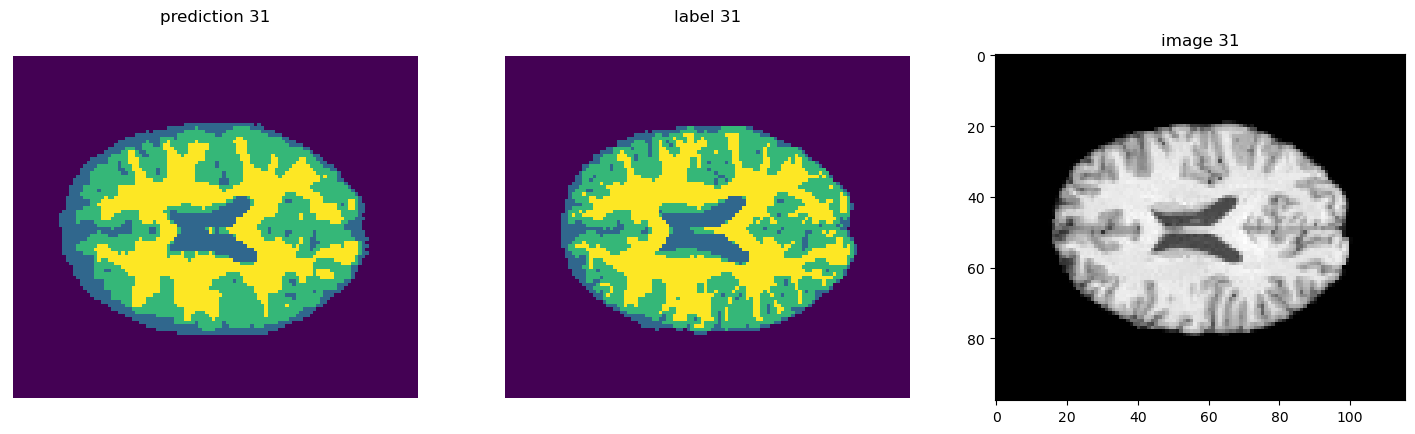

Test Loss: 0.33087811060249805
training of coronal UNet
----------
epoch 1/80
20, train_loss: 0.4462
epoch 1 average loss: 0.4613
----------
epoch 2/80
20, train_loss: 0.4246
epoch 2 average loss: 0.4175
----------
epoch 3/80
20, train_loss: 0.4145
epoch 3 average loss: 0.4092
----------
epoch 4/80
20, train_loss: 0.4066
epoch 4 average loss: 0.4017
----------
epoch 5/80
20, train_loss: 0.4021
saved new best metric model
current epoch: 5 current mean dice: 0.6750
best mean dice: 0.6750 at epoch: 5
epoch 5 average loss: 0.3966
----------
epoch 6/80
20, train_loss: 0.3982
epoch 6 average loss: 0.3926
----------
epoch 7/80
20, train_loss: 0.3950
epoch 7 average loss: 0.3891
----------
epoch 8/80
20, train_loss: 0.3918
epoch 8 average loss: 0.3859
----------
epoch 9/80
20, train_loss: 0.3888
epoch 9 average loss: 0.3830
----------
epoch 10/80
20, train_loss: 0.3859
saved new best metric model
current epoch: 10 current mean dice: 0.6774
best mean dice: 0.6774 at epoch: 10
epoch 10 average l

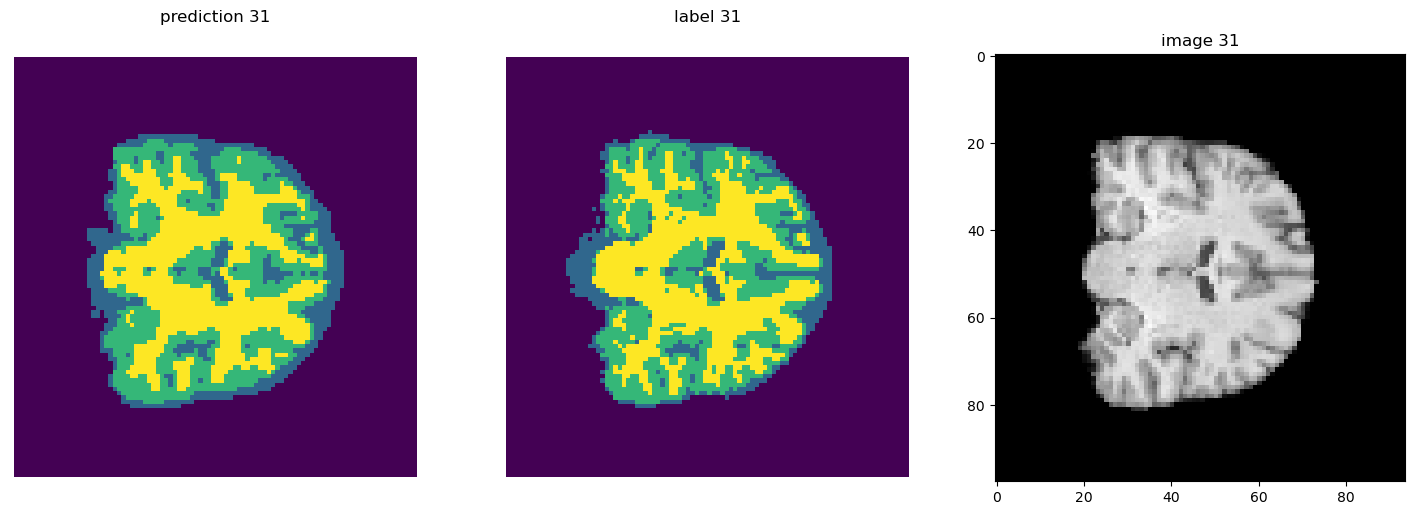

Test Loss: 0.313786624930799
training of sagittal UNet
----------
epoch 1/80
20, train_loss: 0.6429
epoch 1 average loss: 0.6576
----------
epoch 2/80
20, train_loss: 0.4985
epoch 2 average loss: 0.4603
----------
epoch 3/80
20, train_loss: 0.4658
epoch 3 average loss: 0.4253
----------
epoch 4/80
20, train_loss: 0.4498
epoch 4 average loss: 0.4093
----------
epoch 5/80
20, train_loss: 0.4377
saved new best metric model
current epoch: 5 current mean dice: 0.6303
best mean dice: 0.6303 at epoch: 5
epoch 5 average loss: 0.3987
----------
epoch 6/80
20, train_loss: 0.4282
epoch 6 average loss: 0.3907
----------
epoch 7/80
20, train_loss: 0.4209
epoch 7 average loss: 0.3848
----------
epoch 8/80
20, train_loss: 0.4153
epoch 8 average loss: 0.3803
----------
epoch 9/80
20, train_loss: 0.4112
epoch 9 average loss: 0.3766
----------
epoch 10/80
20, train_loss: 0.4081
current epoch: 10 current mean dice: 0.6282
best mean dice: 0.6303 at epoch: 5
epoch 10 average loss: 0.3735
----------
epoch 1

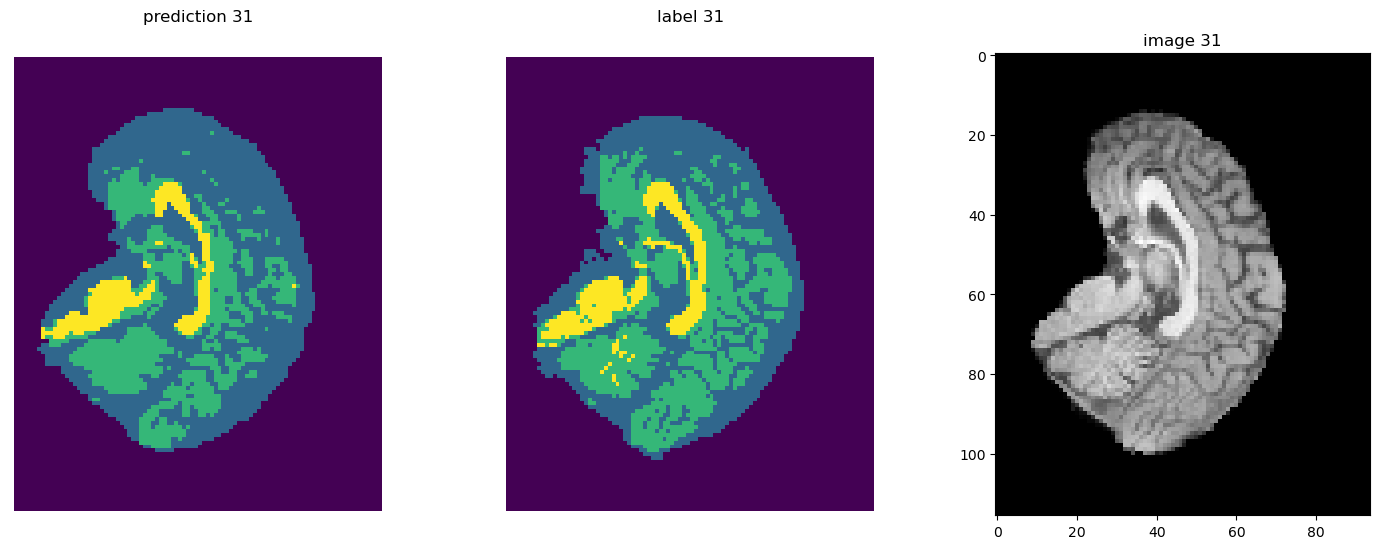

Test Loss: 0.3463131971657276


In [23]:
model = UNet(spatial_dims = 2,
             in_channels = 1,
             out_channels=4,
             channels=(4, 8, 16),
             strides=(2, 2))

epochs = 80
model_axial = train_quicknat(model, train_loader_axial, val_loader_axial, test_loader_axial, epochs, "axial")

model_coronal = train_quicknat(model, train_loader_coronal, val_loader_coronal, test_loader_coronal, epochs, "coronal")

model_sagittal = train_quicknat(model, train_loader_sagittal, val_loader_sagittal, test_loader_sagittal, epochs, "sagittal")



In [24]:
# Define and train a neural network (U-Net) for segmentation
# Implement
# --------------------------- ADD YOUR CODE HERE ------------------------------
pred_seg_3 = get_prediction(model_axial, model_coronal, model_sagittal, test_loader_axial, test_loader_coronal, test_loader_sagittal, 47)
# ----------------------------------- END -------------------------------------

### Evaluate the Dice scores (separately for every tissue type) for the whole test set.

In [ ]:
# Visualize individual segmentation channels for axial slice 47 of all three approaches and the ground truth in a similar style as above
# Implement
# --------------------------- ADD YOUR CODE HERE ------------------------------
plt_seg_1 = None
plt_seg_2 = None
plt_seg_3 = None
plt_gt = None
# ----------------------------------- END -------------------------------------

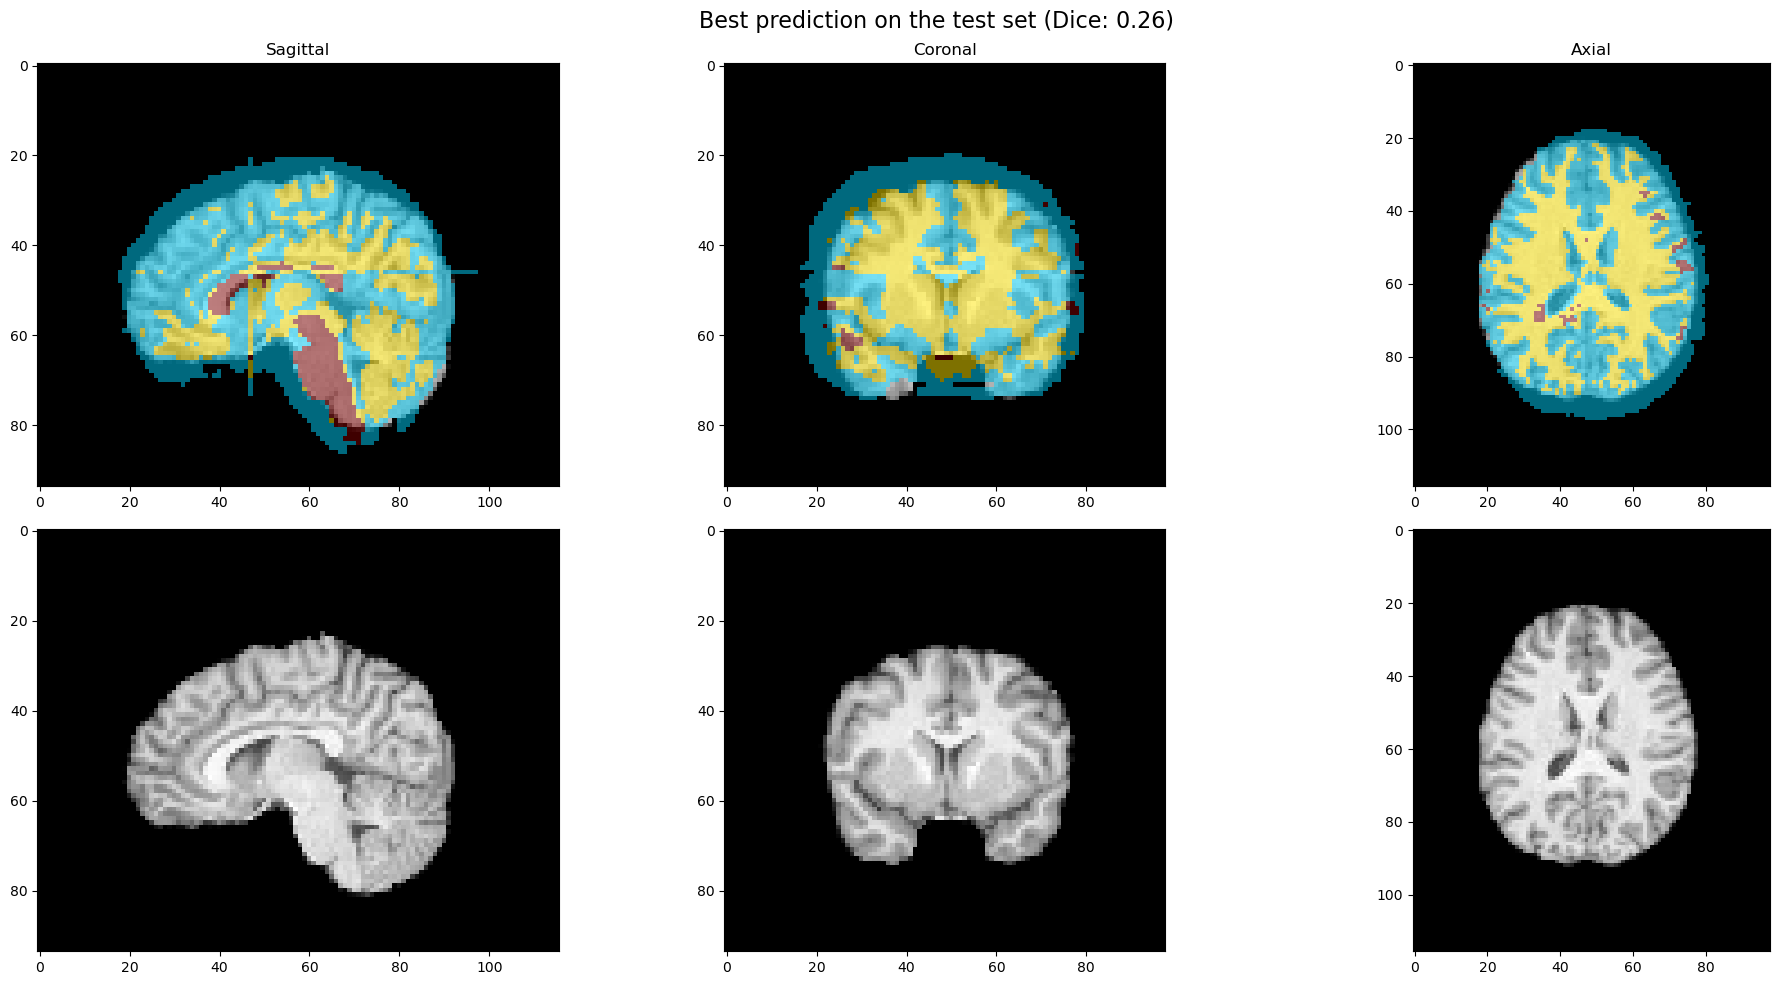

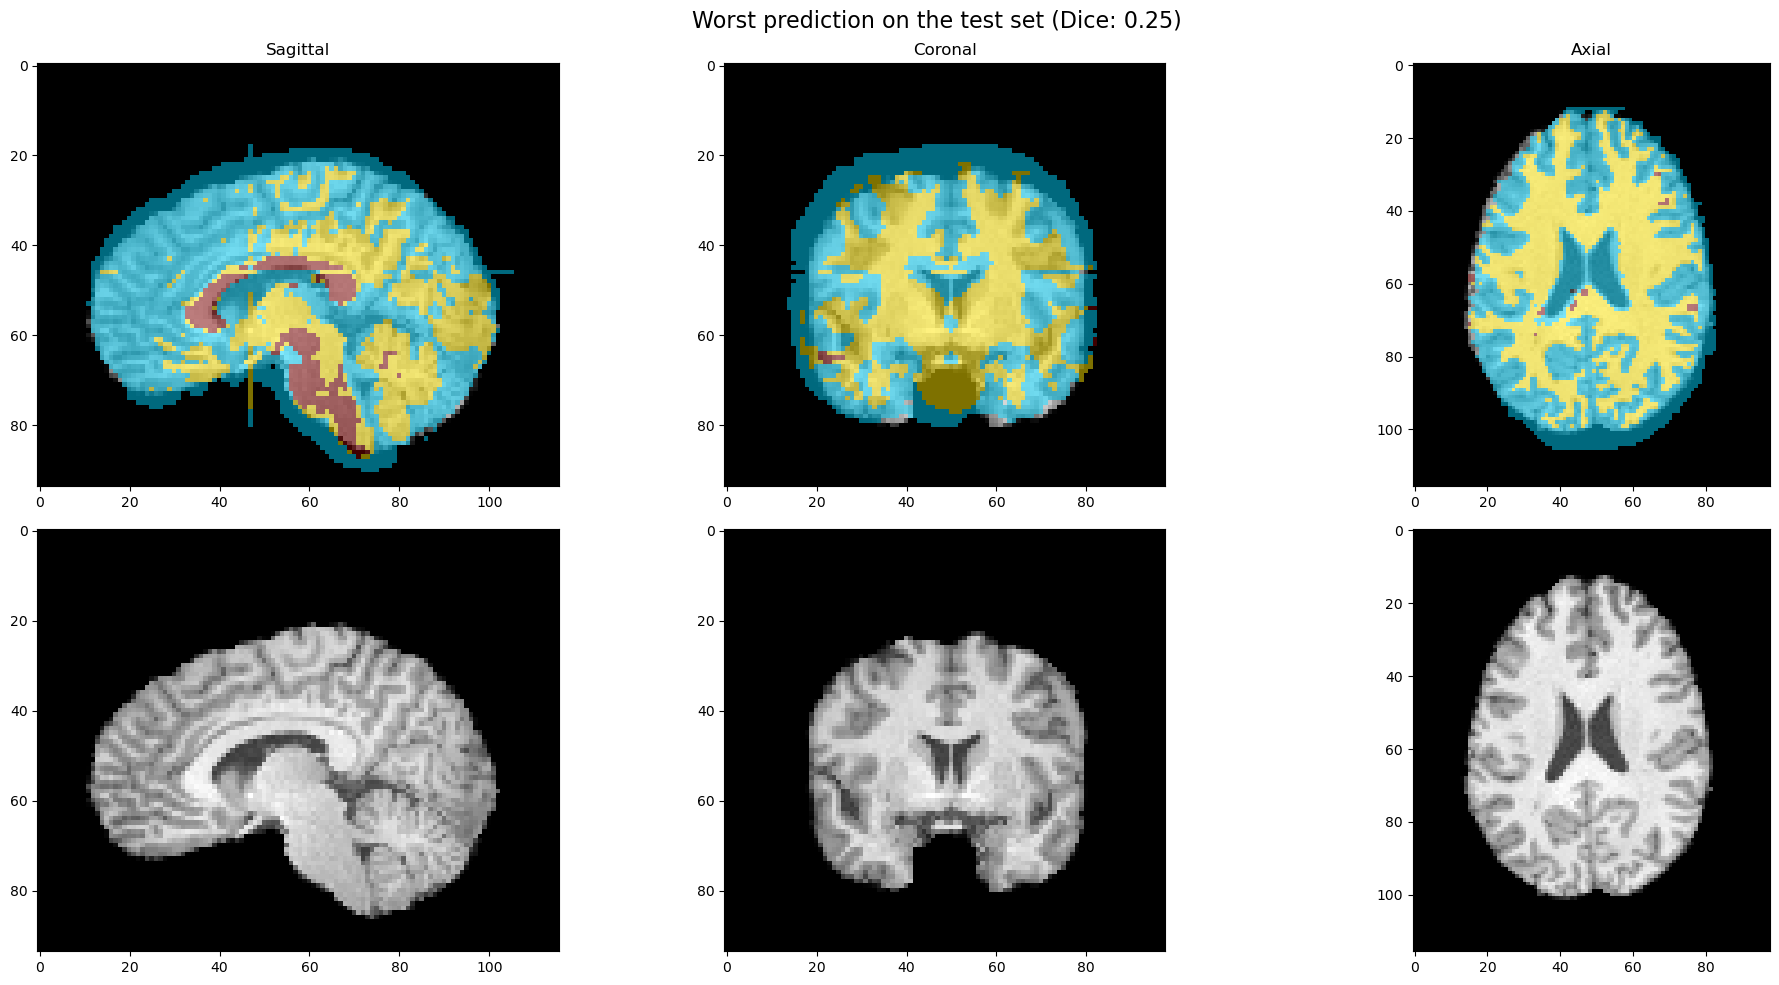

In [26]:
# Run this block after implementing Q3.
visualize_best_and_worst_samples(pred_seg_3)

### Summarize the results of all of the segmentation methods implemented.

In [ ]:
# Run this block after implementing Q1-3.
results_dictionary = {
    'unsupervised1': get_results_dictionary(pred_seg_1),
    'unsupervised2': get_results_dictionary(pred_seg_2),
    'u-net': get_results_dictionary(pred_seg_3),
}
plot_results_summary(results_dictionary)